In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [189]:
df = pd.read_csv('model1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   100 non-null    object 
 1   DataBreachSource       100 non-null    object 
 2   Title                  95 non-null     object 
 3   Channel                100 non-null    object 
 4   Sector                 100 non-null    object 
 5   Author                 42 non-null     object 
 6   VaderSentiment         100 non-null    object 
 7   DataType               80 non-null     object 
 8   PositiveCount          100 non-null    int64  
 9   NegativeCount          100 non-null    int64  
 10  PosNegRatio            100 non-null    float64
 11  PosTotalRatio          100 non-null    float64
 12  AvgPositiveConf        100 non-null    float64
 13  AvgNegativeConf        100 non-null    float64
 14  WordCount              100 non-null    int64  
 15  Sentenc

In [190]:
df.head()

,Name,DataBreachSource,Title,Channel,Sector,Author,VaderSentiment,DataType,PositiveCount,NegativeCount,...,FAQKeywordCount,AvgWordLength,AvgSentenceLength,UniqueWordCount,StopWordCount,CharCount,PunctuationCount,EmailTagCount,TimelagGroupEncoded,CombinedLabel
0,PageUp People,Malicious or criminal attack,Unauthorised Activity on IT System,Website,Information media and telecommunications,Chief Executive Officer,Positive,"name, street address, email address, telephone...",7,3,...,2,5.240566,21.200000,150,91,1349,21,0,0.45,2.0
1,Canva,Malicious or criminal attack,Canva Security Incident  May 24 FAQs,Website,Information media and telecommunications,Head of Security,Neutral,"username, name, email address, country, city, ...",23,24,...,0,4.885478,19.250000,440,376,5118,111,0,0.45,1.0
2,Australian National University,Malicious or criminal attack,Message from the Vice-Chancellor,Website,Education and training,Vice-Chancellor,Positive,"name, address, date of birth, phone number, pe...",21,7,...,1,5.143141,16.833333,281,229,3206,61,1,0.17,2.0
3,Australian Catholic University,Malicious or criminal attack,Cyber attack on ACU IT systems,Website,Education and training,Acting Vice-Chancellor,Positive,"email account, calendar, bank account details",7,9,...,0,5.392523,20.619048,255,169,2799,49,1,0.45,1.0
4,NAB,Human error,NAB apologises to customers for data breach,Website,Financial and insurance services,NaN,Positive,"customer name, date of birth, contact details,...",14,5,...,0,5.308357,14.708333,217,134,2274,52,0,0.45,1.0


### Feature Engineering & Feature Transformation

#### Transform CombinedLabel

In [191]:
# Rename the column
df.rename(columns={'CombinedLabel': 'LevelOfDetail'}, inplace=True)

# Convert the class label from int to string
df['LevelOfDetail'] = df['LevelOfDetail'].astype(str)

In [192]:
label = {'1.0' : 0, '2.0': 1, '3.0': 2} # 0 FullTranparency, 1 Guarded, 2 Opacity

for dataset in [df]:
    dataset['LevelOfDetail'] = dataset['LevelOfDetail'].map(label)

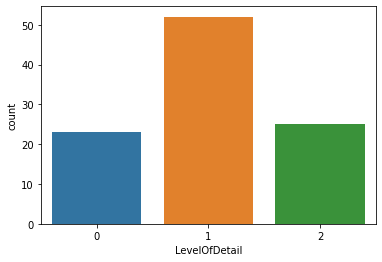

In [193]:
sns.countplot(x='LevelOfDetail', data=df)
plt.show()

In [194]:
df['LevelOfDetail'].value_counts()

1    52
2    25
0    23
Name: LevelOfDetail, dtype: int64

#### Frequency Encoding Categorical features

In [195]:
nominal_col = ['DataBreachSource', 'Channel', 'Sector', 'VaderSentiment']

def freq_encoding(df, nominal_cols):
    for col in nominal_cols:
        # generate the frequency encoding for each categorical value in the target column
        fr_enc = (df.groupby(col).size()) / len(df)

        # # print the encoding values
        # print(fr_enc)

        # create a new column that apply frequency encoding to Age Group
        df[col+"_Encoded"] = df[col].apply(lambda x : fr_enc[x])
        
freq_encoding(df, nominal_col)

In [196]:
df['Sector_Encoded'].value_counts()

0.24    24
0.07    14
0.13    13
0.09     9
0.04     8
0.08     8
0.02     8
0.03     6
0.01     5
0.05     5
Name: Sector_Encoded, dtype: int64

#### Author column

In [197]:
df['Author'].value_counts(dropna=False)

NaN                                   58
Chief Executive Officer               11
Company's Name                         5
Board                                  5
Vice-Chancellor                        3
Managing Director                      2
Chief Information Security Officer     1
Community moderator                    1
VP of Product Management               1
Chief Digital Officer                  1
Vice President Media Relations         1
Chairman                               1
Media contact                          1
Chief Financial Officer                1
Principal                              1
Head of Security                       1
Chief Security Officer                 1
Acting Chief Executive                 1
General Secretary                      1
Company Secretary                      1
Acting Vice-Chancellor                 1
General Manager Corporate HR / IR      1
Name: Author, dtype: int64

In [198]:
isinstance(df['Author'][4], str)

False

In [199]:
# Create new column if there is an author mentioned
df['AuthorMention'] = df['Author'].apply(lambda x: 1 if isinstance(x, str) else 0)

In [200]:
df['AuthorMention'].value_counts()

0    58
1    42
Name: AuthorMention, dtype: int64

#### Title column

In [201]:
df['Title'].head()

0             Unauthorised Activity on IT System
1          Canva Security Incident  May 24 FAQs
2               Message from the Vice-Chancellor
3                 Cyber attack on ACU IT systems
4    NAB apologises to customers for data breach
Name: Title, dtype: object

In [202]:
import string
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [203]:
# Ref: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

# Lemmatize with POS Tag
from nltk.corpus import wordnet
# nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [204]:
def preprocess(text):
    try: 
        # split into sentences
        sentences = sent_tokenize(text)

        # split into words
        tokens = word_tokenize(text)

        # convert to lower case
        tokens = [w.lower() for w in tokens]

        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]

        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]

        # filter out stop words
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]

        # Lemmatise the tokens
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

        # Join the tokens back into a string
        processed_text = ' '.join(lemmatized_tokens)
        return processed_text
    except TypeError:
        return ""

In [205]:
df['Title_nltk'] = df['Title'].apply(lambda x: preprocess(x))

In [206]:
df['Title_nltk'].head()

0           unauthorised activity system
1        canva security incident may faq
2                 message vicechancellor
3                cyber attack acu system
4    nab apologises customer data breach
Name: Title_nltk, dtype: object

##### Topic modelling for Title

In [207]:
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Ref: https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LATENT DIRICHLET ALLOCATION (LDA) TOPIC MODELLING

tf_vectorizer = CountVectorizer(max_df=0.90, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df['Title_nltk'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names_out()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

lda_model = LatentDirichletAllocation(n_components=5,learning_method='online',max_iter=50, random_state=0).fit(tf)
no_top_words = 2
def display_topics(model, feature_names, no_top_words):
    for topix_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topix_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
data incident
Topic 1:
data incident
Topic 2:
incident data
Topic 3:
incident data
Topic 4:
incident data


Summary: All titles revolve around the topic: "data incident."

In [208]:
df['Title'].value_counts(dropna=False)

NaN                                                5
Data Breach                                        2
Cyber Security Incident                            2
Privacy breach                                     2
Cyber Incident                                     2
                                                  ..
IMPORTANT INFORMATION: CTARS DATA BREACH           1
AIS privacy incident                               1
Unauthorised disclosure of personal information    1
Frontier Software Cyber Incident                   1
Appen Advises Of IT Security Incident              1
Name: Title, Length: 92, dtype: int64

In [209]:
# Create new column if there is a title for the statement
df['TitleMention'] = df['Title'].apply(lambda x: 1 if isinstance(x, str) else 0)

In [210]:
df['TitleMention'].value_counts(dropna=False)

1    95
0     5
Name: TitleMention, dtype: int64

#### Datatype

In [211]:
df['DataType']

0     name, street address, email address, telephone...
1     username, name, email address, country, city, ...
2     name, address, date of birth, phone number, pe...
3         email account, calendar, bank account details
4     customer name, date of birth, contact details,...
                            ...                        
95    name, address, country, phone, email, hashed p...
96                    name, phone number, email address
97    name, email address, mobile, Landline phone nu...
98    personal information of Aristocrate employees ...
99    customer and crowd name, company name, email a...
Name: DataType, Length: 100, dtype: object

In [212]:
df['DataType'][0]

'name, street address, email address, telephone number, employment information, gender, date of birth, middle name, nationality, job references, job information, system communication, approval request, agency contacts login detail'

In [213]:
set(df['DataType'][1].split(', '))

{'OAuth login token',
 'city',
 'country',
 'credit card',
 'cryptographically protected password',
 'email address',
 'homepage URL',
 'name',
 'payment data',
 'username'}

In [214]:
len(set(df['DataType'][1].split(', ')))

10

In [215]:
# 20 records without datatype mentioned
df['DataType'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                      20
name, email address, phone number, customer chat transcripts                                                                                                                                                                              2
                                                                                                                                                                                                                                          2
email address, phone number                                                                                                                                                                                                               2
name, street address, email address, telephone number, e

In [216]:
isinstance(df['DataType'][7], str)

False

In [217]:
df['DataTypeCount'] = df['DataType'].apply(lambda x: len(set(x.split(', '))) if isinstance(x, str) else 0)

In [218]:
df['DataTypeCount'].value_counts()

0     20
1     17
2     12
4      8
7      8
3      7
6      7
9      4
10     4
5      4
12     3
14     1
8      1
18     1
13     1
22     1
11     1
Name: DataTypeCount, dtype: int64

In [219]:
df.head()

,Name,DataBreachSource,Title,Channel,Sector,Author,VaderSentiment,DataType,PositiveCount,NegativeCount,...,TimelagGroupEncoded,LevelOfDetail,DataBreachSource_Encoded,Channel_Encoded,Sector_Encoded,VaderSentiment_Encoded,AuthorMention,Title_nltk,TitleMention,DataTypeCount
0,PageUp People,Malicious or criminal attack,Unauthorised Activity on IT System,Website,Information media and telecommunications,Chief Executive Officer,Positive,"name, street address, email address, telephone...",7,3,...,0.45,1,0.75,0.79,0.24,0.77,1,unauthorised activity system,1,14
1,Canva,Malicious or criminal attack,Canva Security Incident  May 24 FAQs,Website,Information media and telecommunications,Head of Security,Neutral,"username, name, email address, country, city, ...",23,24,...,0.45,0,0.75,0.79,0.24,0.19,1,canva security incident may faq,1,10
2,Australian National University,Malicious or criminal attack,Message from the Vice-Chancellor,Website,Education and training,Vice-Chancellor,Positive,"name, address, date of birth, phone number, pe...",21,7,...,0.17,1,0.75,0.79,0.13,0.77,1,message vicechancellor,1,9
3,Australian Catholic University,Malicious or criminal attack,Cyber attack on ACU IT systems,Website,Education and training,Acting Vice-Chancellor,Positive,"email account, calendar, bank account details",7,9,...,0.45,0,0.75,0.79,0.13,0.77,1,cyber attack acu system,1,3
4,NAB,Human error,NAB apologises to customers for data breach,Website,Financial and insurance services,NaN,Positive,"customer name, date of birth, contact details,...",14,5,...,0.45,0,0.18,0.79,0.09,0.77,0,nab apologises customer data breach,1,4


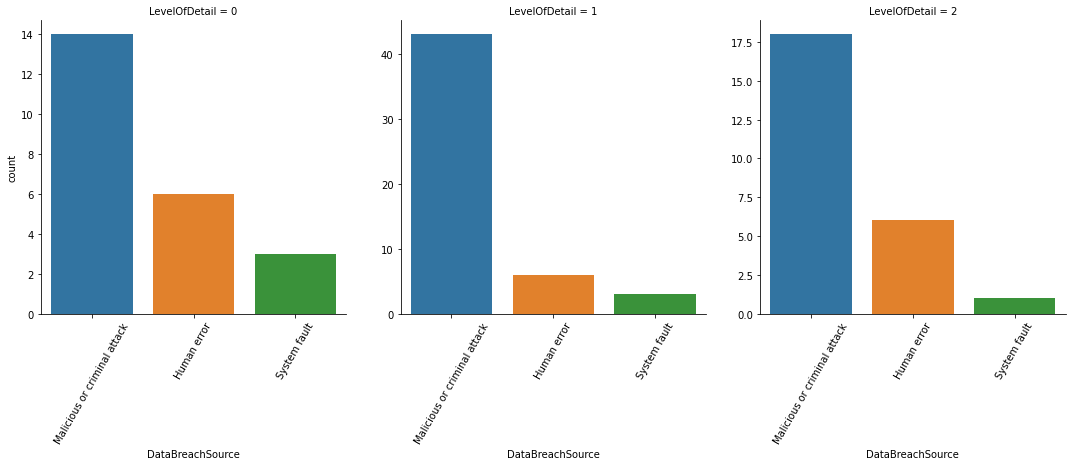

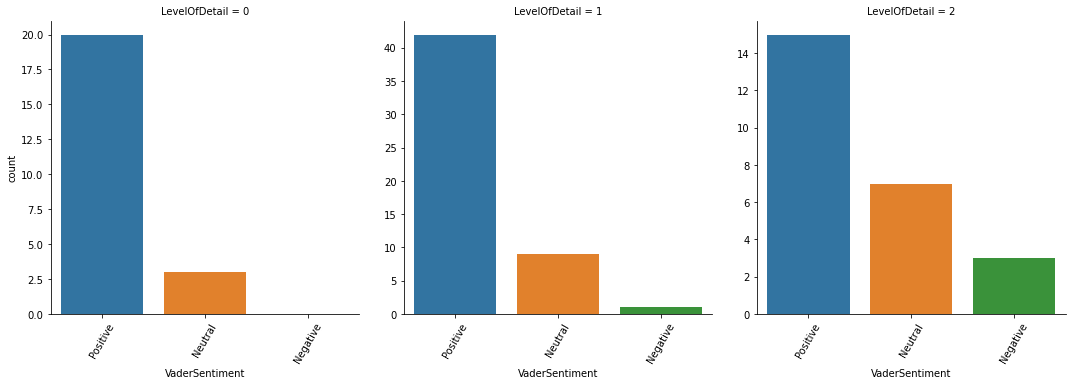

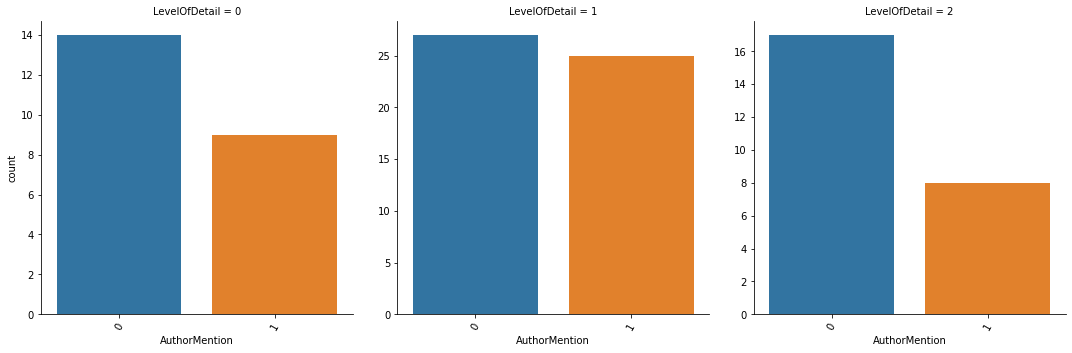

In [222]:
for col in ['DataBreachSource', 'VaderSentiment', 'AuthorMention']:
    g = sns.catplot(x = col, kind='count', col = 'LevelOfDetail', data=df, sharey=False)
    g.set_xticklabels(rotation=60)

### Feature Selection

In [33]:
# Copy certain columns to create a new DataFrame
selected_columns = ['AuthorMention', 'TitleMention', 'DataTypeCount',
    'DataBreachSource_Encoded', 'Channel_Encoded', 'Sector_Encoded', 'VaderSentiment_Encoded',
    'PositiveCount', 'NegativeCount', 'PosNegRatio', 'PosTotalRatio', 'AvgPositiveConf', 'AvgNegativeConf', 
                                              'WordCount', 'SentenceCount', 'ReadingEase', 'Flesch-KincaidGrade', 'HyperlinksCount', 'CyberKeywordCount', 'AuthorityKeywordCount',  'FAQKeywordCount', 
                                             'AvgWordLength', 'AvgSentenceLength', 
    'UniqueWordCount', 'StopWordCount', 'CharCount', 'PunctuationCount', 'EmailTagCount', 'TimelagGroupEncoded',
    'LevelOfDetail']  
# Test modelling for class "LevelDetail"
df = df[selected_columns].copy()

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AuthorMention             100 non-null    int64  
 1   TitleMention              100 non-null    int64  
 2   DataTypeCount             100 non-null    int64  
 3   DataBreachSource_Encoded  100 non-null    float64
 4   Channel_Encoded           100 non-null    float64
 5   Sector_Encoded            100 non-null    float64
 6   VaderSentiment_Encoded    100 non-null    float64
 7   PositiveCount             100 non-null    int64  
 8   NegativeCount             100 non-null    int64  
 9   PosNegRatio               100 non-null    float64
 10  PosTotalRatio             100 non-null    float64
 11  AvgPositiveConf           100 non-null    float64
 12  AvgNegativeConf           100 non-null    float64
 13  WordCount                 100 non-null    int64  
 14  SentenceCou

In [35]:
df.head()

,AuthorMention,TitleMention,DataTypeCount,DataBreachSource_Encoded,Channel_Encoded,Sector_Encoded,VaderSentiment_Encoded,PositiveCount,NegativeCount,PosNegRatio,...,FAQKeywordCount,AvgWordLength,AvgSentenceLength,UniqueWordCount,StopWordCount,CharCount,PunctuationCount,EmailTagCount,TimelagGroupEncoded,LevelOfDetail
0,1,1,14,0.75,0.79,0.24,0.77,7,3,2.333333,...,2,5.240566,21.200000,150,91,1349,21,0,0.45,1
1,1,1,10,0.75,0.79,0.24,0.19,23,24,0.958333,...,0,4.885478,19.250000,440,376,5118,111,0,0.45,0
2,1,1,9,0.75,0.79,0.13,0.77,21,7,3.000000,...,1,5.143141,16.833333,281,229,3206,61,1,0.17,1
3,1,1,3,0.75,0.79,0.13,0.77,7,9,0.777778,...,0,5.392523,20.619048,255,169,2799,49,1,0.45,0
4,0,1,4,0.18,0.79,0.09,0.77,14,5,2.800000,...,0,5.308357,14.708333,217,134,2274,52,0,0.45,0


#### 2. Try Train/Test Split 80, 20 % for all classifiers without standardisation and PCA

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import datasets, preprocessing, svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [37]:
X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Random state 0 results in accuracy of 50% for NB, 65% for SVM linear??? 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80, 29), (80,), (20, 29), (20,))

In [38]:
X.head()

,AuthorMention,TitleMention,DataTypeCount,DataBreachSource_Encoded,Channel_Encoded,Sector_Encoded,VaderSentiment_Encoded,PositiveCount,NegativeCount,PosNegRatio,...,AuthorityKeywordCount,FAQKeywordCount,AvgWordLength,AvgSentenceLength,UniqueWordCount,StopWordCount,CharCount,PunctuationCount,EmailTagCount,TimelagGroupEncoded
0,1,1,14,0.75,0.79,0.24,0.77,7,3,2.333333,...,0,2,5.240566,21.200000,150,91,1349,21,0,0.45
1,1,1,10,0.75,0.79,0.24,0.19,23,24,0.958333,...,0,0,4.885478,19.250000,440,376,5118,111,0,0.45
2,1,1,9,0.75,0.79,0.13,0.77,21,7,3.000000,...,0,1,5.143141,16.833333,281,229,3206,61,1,0.17
3,1,1,3,0.75,0.79,0.13,0.77,7,9,0.777778,...,4,0,5.392523,20.619048,255,169,2799,49,1,0.45
4,0,1,4,0.18,0.79,0.09,0.77,14,5,2.800000,...,1,0,5.308357,14.708333,217,134,2274,52,0,0.45


In [39]:
X.columns

Index(['AuthorMention', 'TitleMention', 'DataTypeCount',
       'DataBreachSource_Encoded', 'Channel_Encoded', 'Sector_Encoded',
       'VaderSentiment_Encoded', 'PositiveCount', 'NegativeCount',
       'PosNegRatio', 'PosTotalRatio', 'AvgPositiveConf', 'AvgNegativeConf',
       'WordCount', 'SentenceCount', 'ReadingEase', 'Flesch-KincaidGrade',
       'HyperlinksCount', 'CyberKeywordCount', 'AuthorityKeywordCount',
       'FAQKeywordCount', 'AvgWordLength', 'AvgSentenceLength',
       'UniqueWordCount', 'StopWordCount', 'CharCount', 'PunctuationCount',
       'EmailTagCount', 'TimelagGroupEncoded'],
      dtype='object')

#### Import libraries

In [46]:
# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, tree, preprocessing, datasets, metrics, linear_model
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, confusion_matrix

import math, time, random, datetime

#### Naive Bayes Gaussian

In [42]:
# fit a GaussianNB classifier to the training set
clf = GaussianNB()
clf.fit(X_train, y_train)

# perform classification on the test set
y_hat = clf.predict(X_test)

# print performance
print("\nPrediction accuracy on the test dataset:")
print("{:.2%}".format(metrics.accuracy_score(y_test, y_hat)))
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_hat).sum()))


Prediction accuracy on the test dataset:
50.00%
Number of mislabeled points out of a total 20 points : 10


#### Support Vector Machines

##### Linear kernel

In [43]:
# # create an instance of the SVM classifier with a Linear kernel
# clf = SVC(kernel='linear')

# # train the model using the training set
# clf.fit(X_train, y_train)

# # predict the classes in the test set
# y_hat = clf.predict(X_test)

# # print accuracy
# print("\nAccuracy: %.3f%%" % (metrics.accuracy_score(y_test, y_hat)*100))

# # get feature weights
# print("\nFeature weights:")
# # get a list of variable (feature) names
# f_names = ['AuthorMention', 'TitleMention', 'DataTypeCount',
#        'DataBreachSource_Encoded', 'Channel_Encoded', 'Sector_Encoded',
#        'VaderSentiment_Encoded', 'PositiveCount', 'NegativeCount',
#        'PosNegRatio', 'PosTotalRatio', 'AvgPositiveConf', 'AvgNegativeConf',
#        'WordCount', 'SentenceCount', 'ReadingEase', 'Flesch-KincaidGrade',
#        'HyperlinksCount', 'CyberKeywordCount', 'AuthorityKeywordCount',
#        'FAQKeywordCount', 'AvgWordLength', 'AvgSentenceLength',
#        'UniqueWordCount', 'StopWordCount', 'CharCount', 'PunctuationCount',
#        'EmailTagCount', 'TimelagGroupEncoded']

# # get each feature weight learned by SVM
# f_weights = clf.coef_[0].tolist()

# # remove any sign from the weights
# f_weights_abs = [abs(x) for x in f_weights]
    
# # match weight with feature name, and sort in descending order of weight
# srt_list = list(zip(f_weights_abs, f_names))
# srt_list.sort(reverse=True)

# # print
# for e in srt_list:
#     print(e[1], ": ", e[0])

DataBreachSource_Encoded has the highest coefficient, most important feature.

##### RBF kernel

In [44]:
clf = SVC(kernel='rbf')  # activate this to train a non-linear SVM

# train the model using the training set
clf.fit(X_train, y_train)

# predict the classes in the test set
y_hat = clf.predict(X_test)

# print accuracy
print("\nAccuracy: %.3f%%" % (metrics.accuracy_score(y_test, y_hat)*100))
# Same with this score
# print("\nAccuracy of clf: %.3f%%" % (clf.score(X_test, y_test)*100))


Accuracy: 55.000%


SUMMARY: The dataset is quite linearly separable as the result for Linear kernel is better than with RBF kernel.

#### Logistic Regression

In [47]:
X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

LRModel=LogisticRegression()
LRModel.fit(X_train, y_train)
y_pred = LRModel.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.60


C:\Apps\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Decision Tree

0.55


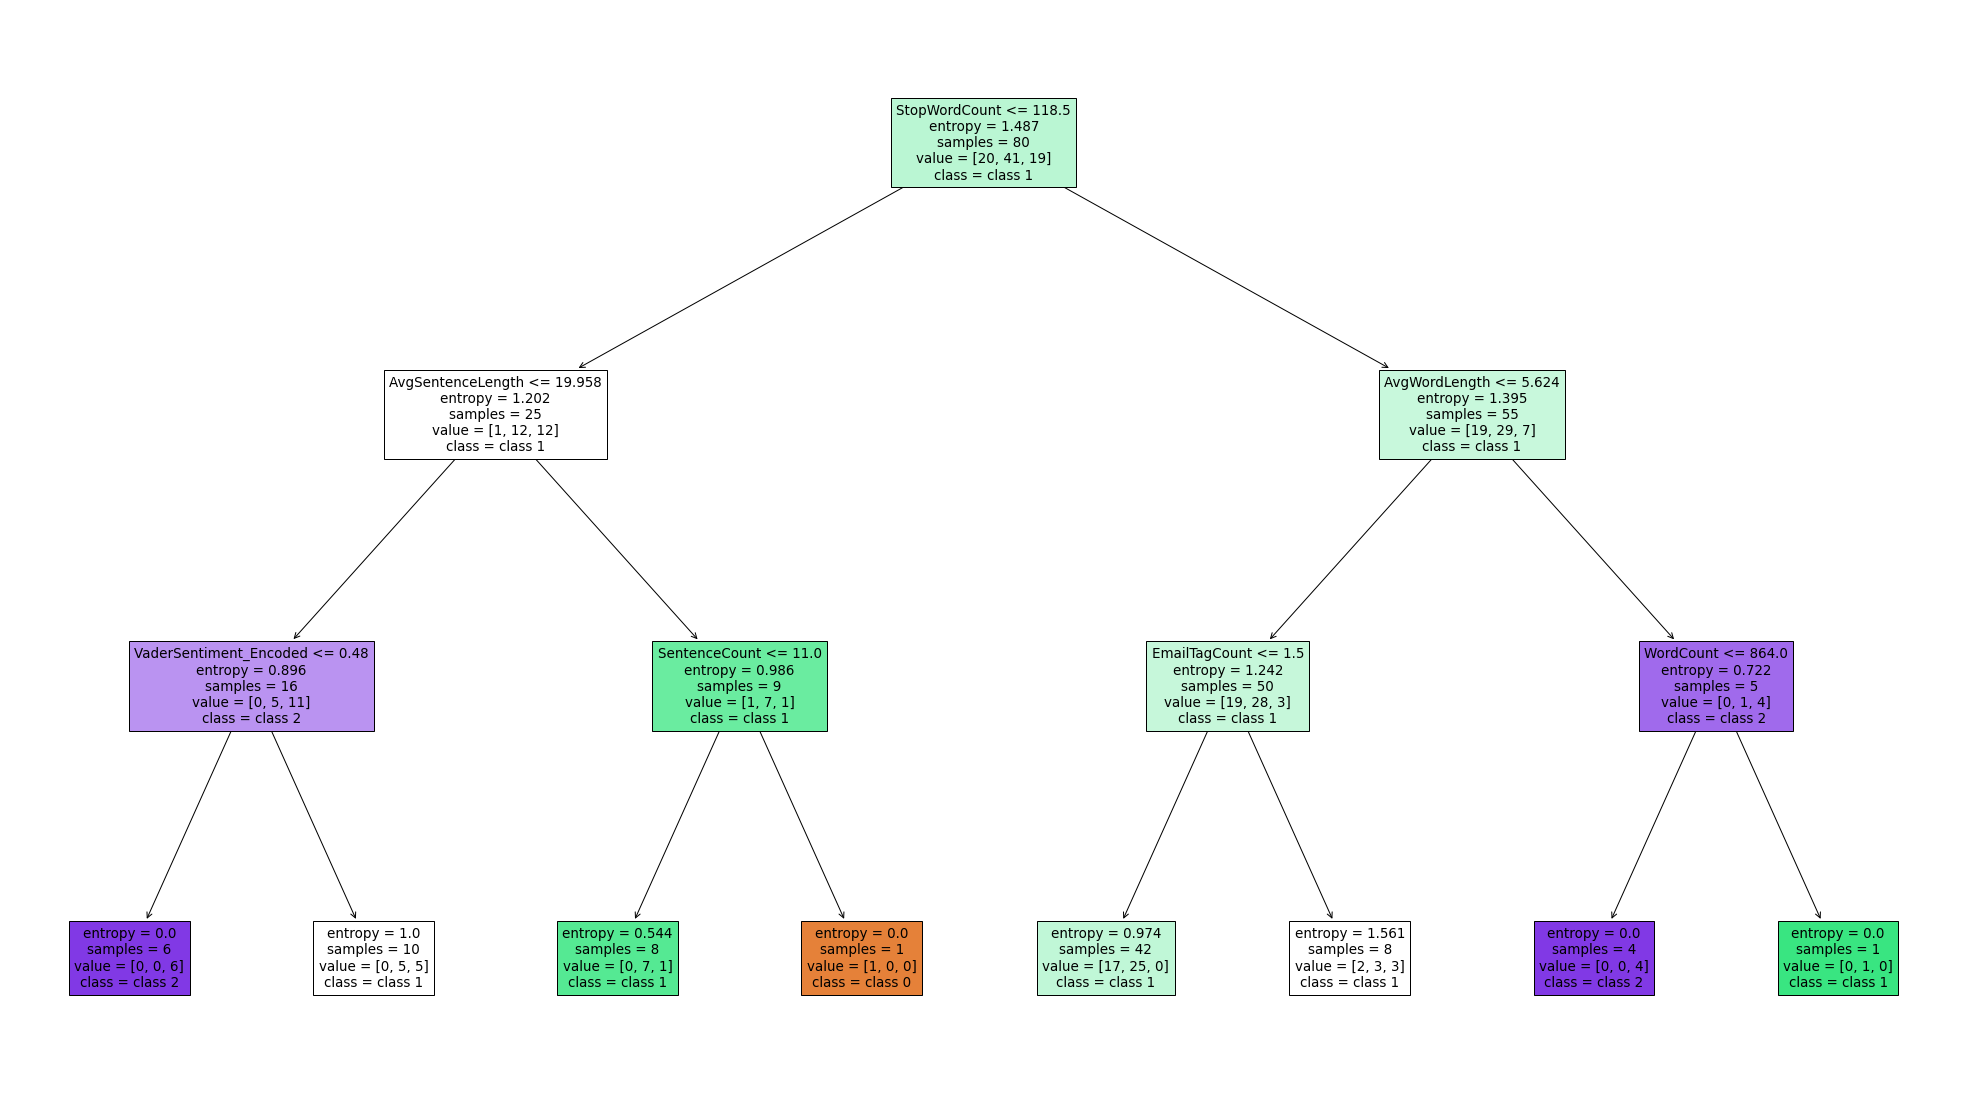

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=3,criterion='entropy')
clf.fit(X_train,y_train)

print(clf.score(X_test,y_test))

fig = plt.figure(figsize=(35,20))


t = tree.plot_tree(clf, feature_names=('AuthorMention', 'TitleMention', 'DataTypeCount',
       'DataBreachSource_Encoded', 'Channel_Encoded', 'Sector_Encoded',
       'VaderSentiment_Encoded', 'PositiveCount', 'NegativeCount',
       'PosNegRatio', 'PosTotalRatio', 'AvgPositiveConf', 'AvgNegativeConf',
       'WordCount', 'SentenceCount', 'ReadingEase', 'Flesch-KincaidGrade',
       'HyperlinksCount', 'CyberKeywordCount', 'AuthorityKeywordCount',
       'FAQKeywordCount', 'AvgWordLength', 'AvgSentenceLength',
       'UniqueWordCount', 'StopWordCount', 'CharCount', 'PunctuationCount',
       'EmailTagCount', 'TimelagGroupEncoded'
       ),
                   class_names=['class 0', 'class 1', 'class 2'],
                   filled=True)

#### Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=3)
clf.fit(X_train,y_train)

print(clf.score(X_test,y_test))

0.65


#### XGBoost

<Figure size 1800x1440 with 0 Axes>

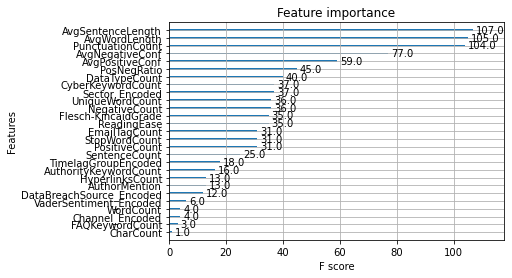

Accuracy: 0.65
Confusion Matrix:
[[2 1 0]
 [2 8 1]
 [0 3 3]]
Classification Report:
              precision    recall  f1-score   support

     class 0       0.50      0.67      0.57         3
     class 1       0.67      0.73      0.70        11
     class 2       0.75      0.50      0.60         6

    accuracy                           0.65        20
   macro avg       0.64      0.63      0.62        20
weighted avg       0.67      0.65      0.65        20



In [62]:
# Ensemble
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(X_train, y_train)

# feature importance

plt.figure(figsize=(25,20))
plot_importance(model)
pyplot.show()

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

target_names = ['class 0', 'class 1', 'class 2']

# Print the classification report
class_report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(class_report)

### Feature Importance

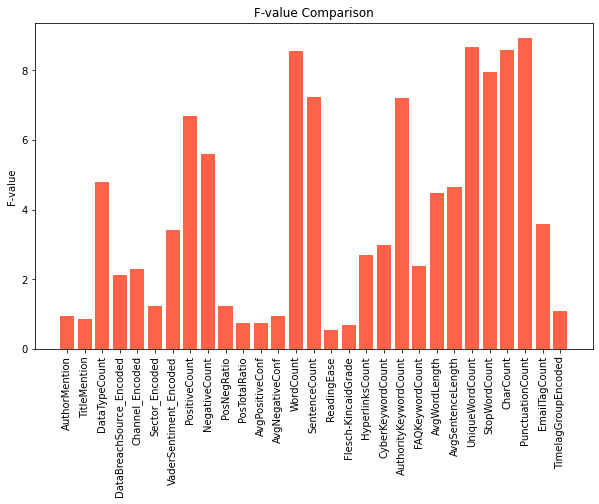

In [51]:
from sklearn.feature_selection import f_classif

X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

# Create f_classif object to calculate F-value
f_value = f_classif(X, y)

plt.figure(figsize=(10,6))
plt.bar(x=X.columns, height=f_value[0], color='tomato')
plt.xticks(rotation='vertical')
plt.ylabel('F-value')
plt.title('F-value Comparison')
plt.show()

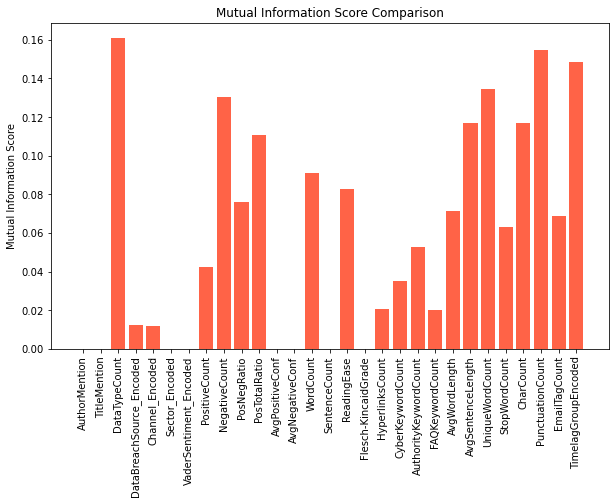

In [52]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

MI_score = mutual_info_classif(X, y, random_state=0)

plt.figure(figsize=(10,6))
plt.bar(x=X.columns, height=MI_score, color='tomato')

plt.xticks(rotation='vertical')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Comparison')

plt.show()

### Using Pipeline 

#### No GridSearch, no k-fold cross validation with Standardisation

In [53]:
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create a dictionary of classifiers
classifiers = {
    'GaussianNB': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine Linear': SVC(kernel='linear'),
    'Support Vector Machine RBF': SVC(kernel='rbf'),
    'XGBoost': xgboost.XGBClassifier(objective="multi:softmax"),
    'KNN': KNeighborsClassifier(n_neighbors=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=4, criterion='entropy'),
    'Random Forest': RandomForestClassifier(max_depth=4)
}

# Create pipelines for each classifier
pipelines = {}
for name, clf in classifiers.items():
    pipelines[name] = Pipeline([
        # ('feature_selector', SelectKBest(score_func=f_classif, k=4)), 
        ('scaler', StandardScaler()),  # Standardize features (optional but often recommended)
        ('classifier', clf)
    ])
    
target_names = ['class 0', 'class 1', 'class 2']

# Train and evaluate each classifier
for name, pipe in pipelines.items():
    
    # Fit classifier
    pipe.fit(X_train, y_train)
    
    # Make prediction
    y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names)
    
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)    
    
    print("="*55)

(80, 29) (80,) (20, 29) (20,)
Classifier: GaussianNB
Accuracy: 0.45
Classification Report:
              precision    recall  f1-score   support

     class 0       0.30      1.00      0.46         3
     class 1       1.00      0.18      0.31        11
     class 2       0.50      0.67      0.57         6

    accuracy                           0.45        20
   macro avg       0.60      0.62      0.45        20
weighted avg       0.74      0.45      0.41        20

Classifier: Logistic Regression
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

     class 0       0.67      0.67      0.67         3
     class 1       0.85      1.00      0.92        11
     class 2       1.00      0.67      0.80         6

    accuracy                           0.85        20
   macro avg       0.84      0.78      0.79        20
weighted avg       0.87      0.85      0.84        20

Classifier: Support Vector Machine Linear
Accuracy: 0.65
Classification Repor

#### No GridSearch, no k-fold cross validation without Standardisation

In [54]:
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create a dictionary of classifiers
classifiers = {
    'GaussianNB': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine Linear': SVC(kernel='linear'),
    'Support Vector Machine RBF': SVC(kernel='rbf'),
    'XGBoost': xgboost.XGBClassifier(objective="multi:softmax"),
    'KNN': KNeighborsClassifier(n_neighbors=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=4, criterion='entropy'),
    'Random Forest': RandomForestClassifier(max_depth=4)
}

# Create pipelines for each classifier
pipelines = {}
for name, clf in classifiers.items():
    pipelines[name] = Pipeline([
        ('classifier', clf)
    ])
    
target_names = ['class 0', 'class 1', 'class 2']

# Train and evaluate each classifier
for name, pipe in pipelines.items():
    
    # Fit classifier
    pipe.fit(X_train, y_train)
    
    # Make prediction
    y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names)
    
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)    
    
    print("="*55)

(80, 29) (80,) (20, 29) (20,)
Classifier: GaussianNB
Accuracy: 0.50
Classification Report:
              precision    recall  f1-score   support

     class 0       0.75      1.00      0.86         3
     class 1       0.60      0.27      0.37        11
     class 2       0.36      0.67      0.47         6

    accuracy                           0.50        20
   macro avg       0.57      0.65      0.57        20
weighted avg       0.55      0.50      0.48        20

Classifier: Logistic Regression
Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

     class 0       0.50      0.33      0.40         3
     class 1       0.80      0.73      0.76        11
     class 2       0.38      0.50      0.43         6

    accuracy                           0.60        20
   macro avg       0.56      0.52      0.53        20
weighted avg       0.63      0.60      0.61        20

Classifier: Support Vector Machine Linear
Accuracy: 0.65
Classification Repor

SUMMARY: Differences in results between standardisation and non-standardisation

- Logistic regression (0.85) with standardisation, (0.60) without standardisation
- Decision tree (0.65) with standardisation, (0.75) without standardisation
- Gaussian (0.45) with standardisation, (0.50) without standardisation

There is no difference in results for other 5 classifiers.

### Try SelectKBest with SVM linear

In [57]:
# Ref: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC

X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))
clf.fit(X_train, y_train)
print(
    "Classification accuracy without selecting features: {:.3f}".format(
        clf.score(X_test, y_test)
    )
)

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

Classification accuracy without selecting features: 0.650


In [58]:
clf_selected = make_pipeline(
    SelectKBest(f_classif, k=25), StandardScaler(), SVC(kernel='linear')
)
clf_selected.fit(X_train, y_train)
print(
    "Classification accuracy after univariate feature selection: {:.3f}".format(
        clf_selected.score(X_test, y_test)
    )
)

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

Classification accuracy after univariate feature selection: 0.600


SUMMARY: Model performs better without selecting features.

### Fine tuning hyperparameters for SVM

### k-fold Cross-validation without Grid Search

As the simple train / test split might not be representative of the model's performance, we'll perform cross-validation.

#### SVC Linear

In [71]:
from statistics import mean

# B. Prepate the dataset
X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

# C. Prepare Cross Validator and the scoring schemes

scoring = ['accuracy', 'recall_macro', 'precision_macro', 'f1_macro']

# D. Build a cross validation pipeline
pipe = make_pipeline(preprocessing.StandardScaler(), svm.SVC(kernel='linear'))


# E. Evaluate the model
scores = cross_validate(pipe, X, y, cv=10, scoring=scoring)


# accuracy
print("Mean accuracy: %.3f%%" % (mean(scores['test_accuracy'])*100))

# precision
print("Mean precision: %.3f " % (mean(scores['test_precision_macro'])))

# recall
print("Mean recall: %.3f" % (mean(scores['test_recall_macro'])))

# # F1 (F-Measure)
print("Mean F1: %.3f" % (mean(scores['test_f1_macro'])))


Mean accuracy: 42.000%
Mean precision: 0.363 
Mean recall: 0.371
Mean F1: 0.346


In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df.iloc[:,:-1].values
X_train = df.drop(columns='LevelOfDetail')
y_train = df['LevelOfDetail']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X.shape[1] - n_over_95 + 1
print("Number features: {}\tTotal Variance Explained: {}".format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

Number features: 16	Total Variance Explained: 0.9579776542169016


In [83]:
# Create a dictionary of classifiers
classifiers = {
    'GaussianNB': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine Linear': SVC(kernel='linear'),
    'Support Vector Machine RBF': SVC(kernel='rbf'),
    'XGBoost': xgboost.XGBClassifier(objective="multi:softmax"),
    'KNN': KNeighborsClassifier(n_neighbors=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=4, criterion='entropy'),
    'Random Forest': RandomForestClassifier(max_depth=4)
}

# Create pipelines for each classifier
pipelines = {}
for name, clf in classifiers.items():
    pipelines[name] = make_pipeline(SelectKBest(f_classif, k=16), 
                                    StandardScaler(), clf)

scoring = ['accuracy', 'recall_macro', 'precision_macro', 'f1_macro']

# Train and evaluate each classifier
for name, pipe in pipelines.items():
    
    print(f"Classifier: {name}")
    
    # E. Evaluate the model
    scores = cross_validate(pipe, X, y, cv=10, scoring=scoring)

    # accuracy
    print("Mean accuracy: %.2f%%" % (mean(scores['test_accuracy'])*100))

    # precision
    print("Mean precision: %.2f " % (mean(scores['test_precision_macro'])))

    # recall
    print("Mean recall: %.2f" % (mean(scores['test_recall_macro'])))

    # # F1 (F-Measure)
    print("Mean F1: %.2f" % (mean(scores['test_f1_macro'])))
    
    print("="*45)

Classifier: GaussianNB
Mean accuracy: 39.00%
Mean precision: 0.40 
Mean recall: 0.43
Mean F1: 0.36
Classifier: Logistic Regression
Mean accuracy: 52.00%
Mean precision: 0.44 
Mean recall: 0.45
Mean F1: 0.42
Classifier: Support Vector Machine Linear
Mean accuracy: 50.00%
Mean precision: 0.50 
Mean recall: 0.44
Mean F1: 0.43
Classifier: Support Vector Machine RBF
Mean accuracy: 46.00%
Mean precision: 0.29 
Mean recall: 0.33
Mean F1: 0.29
Classifier: XGBoost
Mean accuracy: 49.00%
Mean precision: 0.44 
Mean recall: 0.41
Mean F1: 0.40
Classifier: KNN
Mean accuracy: 51.00%
Mean precision: 0.30 
Mean recall: 0.36
Mean F1: 0.30
Classifier: Decision Tree
Mean accuracy: 41.00%
Mean precision: 0.37 
Mean recall: 0.35
Mean F1: 0.33
Classifier: Random Forest
Mean accuracy: 51.00%
Mean precision: 0.40 
Mean recall: 0.40
Mean F1: 0.37


With SelectKBest, Standardisation, results are highest for Logistic regression with 52%.

In [87]:
# Create a dictionary of classifiers
classifiers = {
    'GaussianNB': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine Linear': SVC(kernel='linear'),
    'Support Vector Machine RBF': SVC(kernel='rbf'),
    'XGBoost': xgboost.XGBClassifier(objective="multi:softmax"),
    'KNN': KNeighborsClassifier(n_neighbors=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=4, criterion='entropy'),
    'Random Forest': RandomForestClassifier(max_depth=4)
}

# Create pipelines for each classifier
pipelines = {}
for name, clf in classifiers.items():
    pipelines[name] = make_pipeline(#SelectKBest(f_classif, k=16), 
                                    StandardScaler(), PCA(n_components=5), clf)

scoring = ['accuracy', 'recall_macro', 'precision_macro', 'f1_macro']

# Train and evaluate each classifier
for name, pipe in pipelines.items():
    
    print(f"Classifier: {name}")
    
    # E. Evaluate the model
    scores = cross_validate(pipe, X, y, cv=10, scoring=scoring)

    # accuracy
    print("Mean accuracy: %.2f%%" % (mean(scores['test_accuracy'])*100))

    # precision
    print("Mean precision: %.2f " % (mean(scores['test_precision_macro'])))

    # recall
    print("Mean recall: %.2f" % (mean(scores['test_recall_macro'])))

    # # F1 (F-Measure)
    print("Mean F1: %.2f" % (mean(scores['test_f1_macro'])))
    
    print("="*45)

Classifier: GaussianNB
Mean accuracy: 57.00%
Mean precision: 0.48 
Mean recall: 0.47
Mean F1: 0.44
Classifier: Logistic Regression
Mean accuracy: 58.00%
Mean precision: 0.49 
Mean recall: 0.48
Mean F1: 0.45
Classifier: Support Vector Machine Linear
Mean accuracy: 52.00%
Mean precision: 0.39 
Mean recall: 0.42
Mean F1: 0.37
Classifier: Support Vector Machine RBF
Mean accuracy: 49.00%
Mean precision: 0.23 
Mean recall: 0.33
Mean F1: 0.26
Classifier: XGBoost
Mean accuracy: 54.00%
Mean precision: 0.44 
Mean recall: 0.44
Mean F1: 0.42
Classifier: KNN
Mean accuracy: 54.00%
Mean precision: 0.32 
Mean recall: 0.38
Mean F1: 0.32
Classifier: Decision Tree
Mean accuracy: 51.00%
Mean precision: 0.43 
Mean recall: 0.44
Mean F1: 0.42
Classifier: Random Forest
Mean accuracy: 51.00%
Mean precision: 0.31 
Mean recall: 0.37
Mean F1: 0.32


With Standardisation, PCA(n=5) results are highest for Logistic Regression with 58%.

### Fine-tuning without PCA

In [150]:
X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

# Step 1: Splitting data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [115]:
# # Ref: https://www.kaggle.com/code/ceyhunsahin/rus-gridsearch-private-score-0-4

# def modelPipelineGrid(X_train, y_train, nfolds):
#     scores_Cv = []
    
#     # nb = GaussianNB()
#     log_reg = LogisticRegression()
#     knn = KNeighborsClassifier()
#     svm = SVC()
#     # mlp = MLPClassifier(max_iter=500, **rs)
#     dt = DecisionTreeClassifier()
#     rf = RandomForestClassifier()
#     xgb = XGBClassifier()
 
#     # Dictionary of parameters
    
#     xgb_params = {'n_estimators':range(5,100,5), 'max_depth': [5, 7, 10,15], 'learning_rate':[0.1, 0.05]}

#     log_reg_params = {'C': [0.1, 3, 50]}

#     knn_params = {'n_neighbors':range(2,200,2)}

#     random_params = {'n_estimators':range(5,50,5), 'max_depth': [5, 7, 10]}

#     dt_params = {'criterion' : ['gini', 'entropy'],  'max_depth' : [2,4,6,8,10]}

#     svm_params = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

#     clfs = [
#             # ('Naive Bayes', nb, nb_params)
#             ('Logistic Regression', log_reg,log_reg_params),
#             ('K-Nearest Neighbors', knn,knn_params),
#             ('SVM', svm,svm_params),
#             ('Decision Tree', dt, dt_params),
#             ('Random Forest', rf, random_params),
#             ('XGBoost', xgb, xgb_params),
#             ]

    
#     for clf_name, clf, param_grid in clfs:

#         pipe = Pipeline(steps=[
#                                    ('std', StandardScaler()),
#                                    ('classifier', clf)
#                                    ]
#                             )

#         search = GridSearchCV(pipe, 
#                               {f'classifier__{paramname}': paramvalue for paramname, paramvalue in param_grid.items()},
#                               cv = nfolds)
#         search.fit(X_train, y_train)
#         scores_Cv.append({'model':clf_name, 'best_score ROC_AUC':search.best_score_, 'best parameters':search.best_params_,
#                           'Best model':search.best_estimator_,'Refit Time(s)':search.refit_time_})

#     return scores_Cv

In [146]:
# scores1 = modelPipelineGrid(X_train, y_train, 10)

In [149]:
scores1

[{'model': 'Logistic Regression',
  'best_score ROC_AUC': 0.4125,
  'best parameters': {'classifier__C': 0.1},
  'Best model': Pipeline(steps=[('std', StandardScaler()),
                  ('classifier', LogisticRegression(C=0.1))]),
  'Refit Time(s)': 0.0},
 {'model': 'K-Nearest Neighbors',
  'best_score ROC_AUC': 0.5125,
  'best parameters': {'classifier__n_neighbors': 28},
  'Best model': Pipeline(steps=[('std', StandardScaler()),
                  ('classifier', KNeighborsClassifier(n_neighbors=28))]),
  'Refit Time(s)': 0.004015922546386719},
 {'model': 'SVM',
  'best_score ROC_AUC': 0.5125,
  'best parameters': {'classifier__C': 0.1,
   'classifier__gamma': 1,
   'classifier__kernel': 'rbf'},
  'Best model': Pipeline(steps=[('std', StandardScaler()), ('classifier', SVC(C=0.1, gamma=1))]),
  'Refit Time(s)': 0.0},
 {'model': 'Decision Tree',
  'best_score ROC_AUC': 0.4875,
  'best parameters': {'classifier__criterion': 'entropy',
   'classifier__max_depth': 2},
  'Best model': Pipe

In [147]:
df_scores_GS1 = pd.DataFrame(scores1)
df_scores_avec_GS1 = pd.DataFrame()

for i in df_scores_GS1.index:
    model = df_scores_GS1.iloc[i, 3]
    y_model_pred = model.predict(X_test)
    result3= []
    result3.append({'model': df_scores_GS.iloc[i, 0], 'F1_score': f1_score(y_test, y_model_pred, average='macro'), 
                    'Precision': precision_score(y_test,y_model_pred, average='macro'), 'Recall': recall_score(y_test, y_model_pred, average='macro'),
                    'Accuracy': accuracy_score(y_test, y_model_pred),
                    })
    df_scores_avec_GS1 = df_scores_avec_GS1.append(result3, ignore_index=True)

In [148]:
df_scores_avec_GS1

,model,F1_score,Precision,Recall,Accuracy
0,Logistic Regression,0.770940,0.911111,0.722222,0.80
1,K-Nearest Neighbors,0.236559,0.183333,0.333333,0.55
2,SVM,0.236559,0.183333,0.333333,0.55
3,Decision Tree,0.455128,0.421245,0.494949,0.65
4,Random Forest,0.537374,0.571795,0.520202,0.60
5,XGBoost,0.415152,0.398485,0.459596,0.45


### Fine-tuning with PCA included 

In [125]:
# # Ref: https://www.kaggle.com/code/ceyhunsahin/rus-gridsearch-private-score-0-4

# def modelPipelineGrid2(X_train, y_train, nfolds):
#     scores_Cv = []
    
#     # nb = GaussianNB()
#     log_reg = LogisticRegression()
#     knn = KNeighborsClassifier()
#     svm = SVC()
#     # mlp = MLPClassifier(max_iter=500, **rs)
#     dt = DecisionTreeClassifier()
#     rf = RandomForestClassifier()
#     xgb = XGBClassifier()
 
#     # Dictionary of parameters
    
#     xgb_params = {'n_estimators':range(5,100,5), 'max_depth': [5, 7, 10,15], 'learning_rate':[0.1, 0.05]}

#     log_reg_params = {'C': [0.1, 3, 50]}

#     knn_params = {'n_neighbors':range(2,200,2)}

#     random_params = {'n_estimators':range(5,50,5), 'max_depth': [5, 7, 10]}

#     dt_params = {'criterion' : ['gini', 'entropy'],  'max_depth' : [2,4,6,8,10]}

#     svm_params = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

#     clfs = [
#             # ('Naive Bayes', nb, nb_params)
#             ('Logistic Regression', log_reg,log_reg_params),
#             ('K-Nearest Neighbors', knn,knn_params),
#             ('SVM', svm,svm_params),
#             ('Decision Tree', dt, dt_params),
#             ('Random Forest', rf, random_params),
#             ('XGBoost', xgb, xgb_params),
#             ]

    
#     for clf_name, clf, param_grid in clfs:

#         pipe = Pipeline(steps=[
#                                     ('std', StandardScaler()),
#                                     ('pca', PCA(n_components=16)),
#                                    ('classifier', clf)
#                                    ]
#                             )

#         search = GridSearchCV(pipe, 
#                               {f'classifier__{paramname}': paramvalue for paramname, paramvalue in param_grid.items()},
#                               cv = nfolds)
#         search.fit(X_train, y_train)
#         scores_Cv.append({'model':clf_name, 'best_score ROC_AUC':search.best_score_, 'best parameters':search.best_params_,
#                           'Best model':search.best_estimator_,'Refit Time(s)':search.refit_time_})

#     return scores_Cv

In [127]:
# scores2 = modelPipelineGrid2(X_train, y_train, 10)

In [128]:
scores2

[{'model': 'Logistic Regression',
  'best_score ROC_AUC': 0.4375,
  'best parameters': {'classifier__C': 0.1},
  'Best model': Pipeline(steps=[('std', StandardScaler()), ('pca', PCA(n_components=16)),
                  ('classifier', LogisticRegression(C=0.1))]),
  'Refit Time(s)': 0.01562952995300293},
 {'model': 'K-Nearest Neighbors',
  'best_score ROC_AUC': 0.5125,
  'best parameters': {'classifier__n_neighbors': 30},
  'Best model': Pipeline(steps=[('std', StandardScaler()), ('pca', PCA(n_components=16)),
                  ('classifier', KNeighborsClassifier(n_neighbors=30))]),
  'Refit Time(s)': 0.015631437301635742},
 {'model': 'SVM',
  'best_score ROC_AUC': 0.5125,
  'best parameters': {'classifier__C': 0.1,
   'classifier__gamma': 1,
   'classifier__kernel': 'rbf'},
  'Best model': Pipeline(steps=[('std', StandardScaler()), ('pca', PCA(n_components=16)),
                  ('classifier', SVC(C=0.1, gamma=1))]),
  'Refit Time(s)': 0.0},
 {'model': 'Decision Tree',
  'best_score R

In [129]:
df_scores_GS = pd.DataFrame(scores2)
df_scores_GS

,model,best_score ROC_AUC,best parameters,Best model,Refit Time(s)
0,Logistic Regression,0.4375,{'classifier__C': 0.1},"(StandardScaler(), PCA(n_components=16), Logis...",0.015630
1,K-Nearest Neighbors,0.5125,{'classifier__n_neighbors': 30},"(StandardScaler(), PCA(n_components=16), KNeig...",0.015631
2,SVM,0.5125,"{'classifier__C': 0.1, 'classifier__gamma': 1,...","(StandardScaler(), PCA(n_components=16), SVC(C...",0.000000
3,Decision Tree,0.4625,"{'classifier__criterion': 'gini', 'classifier_...","(StandardScaler(), PCA(n_components=16), Decis...",0.000000
4,Random Forest,0.4875,"{'classifier__max_depth': 7, 'classifier__n_es...","(StandardScaler(), PCA(n_components=16), (Deci...",0.074189
5,XGBoost,0.5250,"{'classifier__learning_rate': 0.05, 'classifie...","(StandardScaler(), PCA(n_components=16), XGBCl...",0.015627


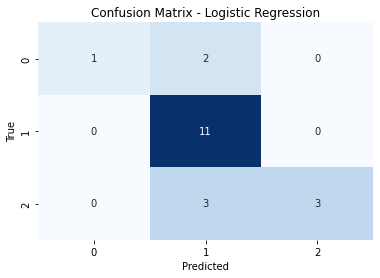

Classification Report:
              precision    recall  f1-score   support

     class 0       1.00      0.33      0.50         3
     class 1       0.69      1.00      0.81        11
     class 2       1.00      0.50      0.67         6

    accuracy                           0.75        20
   macro avg       0.90      0.61      0.66        20
weighted avg       0.83      0.75      0.72        20



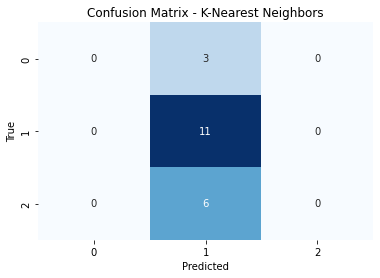

Classification Report:
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.55      1.00      0.71        11
     class 2       0.00      0.00      0.00         6

    accuracy                           0.55        20
   macro avg       0.18      0.33      0.24        20
weighted avg       0.30      0.55      0.39        20



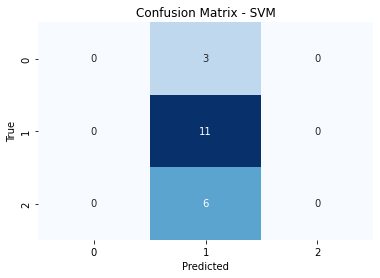

Classification Report:
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.55      1.00      0.71        11
     class 2       0.00      0.00      0.00         6

    accuracy                           0.55        20
   macro avg       0.18      0.33      0.24        20
weighted avg       0.30      0.55      0.39        20



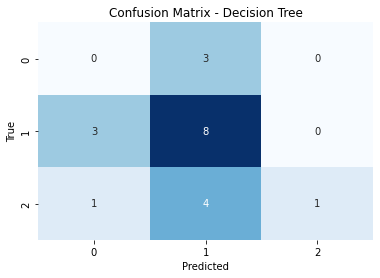

Classification Report:
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.53      0.73      0.62        11
     class 2       1.00      0.17      0.29         6

    accuracy                           0.45        20
   macro avg       0.51      0.30      0.30        20
weighted avg       0.59      0.45      0.42        20



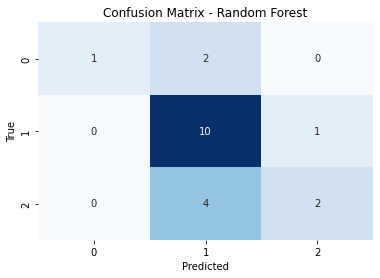

Classification Report:
              precision    recall  f1-score   support

     class 0       1.00      0.33      0.50         3
     class 1       0.62      0.91      0.74        11
     class 2       0.67      0.33      0.44         6

    accuracy                           0.65        20
   macro avg       0.76      0.53      0.56        20
weighted avg       0.69      0.65      0.62        20



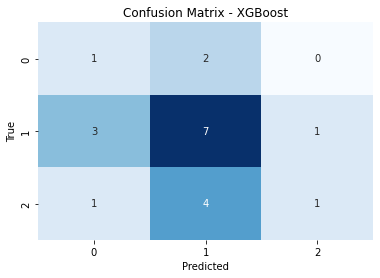

Classification Report:
              precision    recall  f1-score   support

     class 0       0.20      0.33      0.25         3
     class 1       0.54      0.64      0.58        11
     class 2       0.50      0.17      0.25         6

    accuracy                           0.45        20
   macro avg       0.41      0.38      0.36        20
weighted avg       0.48      0.45      0.43        20



In [227]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
df_scores_avec_GS = pd.DataFrame()
target_names = ['class 0', 'class 1', 'class 2']

for i in df_scores_GS.index:
    model = df_scores_GS.iloc[i, 3]
    y_model_pred = model.predict(X_test)
    result3= []
    result3.append({'model': df_scores_GS.iloc[i, 0], 'F1_score': f1_score(y_test, y_model_pred, average='macro'), 
                    'Precision': precision_score(y_test,y_model_pred, average='macro'), 'Recall': recall_score(y_test, y_model_pred, average='macro'),
                    'Accuracy': accuracy_score(y_test, y_model_pred),
                    })
    df_scores_avec_GS = df_scores_avec_GS.append(result3, ignore_index=True)
    
    cm = confusion_matrix(y_test, y_model_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {df_scores_GS.iloc[i, 0]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Print the classification report
    class_report = classification_report(y_test, y_model_pred, target_names=target_names)
    print("Classification Report:")
    print(class_report)    
    print("="*60)


In [ ]:
df_scores_avec_GS

,model,F1_score,Precision,Recall,Accuracy
0,Logistic Regression,0.660494,0.895833,0.611111,0.75
1,K-Nearest Neighbors,0.236559,0.183333,0.333333,0.55
2,SVM,0.236559,0.183333,0.333333,0.55
3,Decision Tree,0.300366,0.511111,0.297980,0.45
4,Random Forest,0.561728,0.763889,0.525253,0.65
5,XGBoost,0.361111,0.412821,0.378788,0.45


In [ ]:
# Ref: https://towardsdatascience.com/cross-validation-and-grid-search-efa64b127c1b
# Ref: https://towardsdatascience.com/random-forest-classification-678e551462f5